            timestamp  hour day_of_week  is_holiday weather wave_quality  \
0 2024-01-01 00:00:00     0      Monday           1  Cloudy    Excellent   
1 2024-01-01 01:00:00     1      Monday           1  Cloudy    Excellent   
2 2024-01-01 02:00:00     2      Monday           1   Foggy    Excellent   
3 2024-01-01 03:00:00     3      Monday           1   Sunny    Excellent   
4 2024-01-01 04:00:00     4      Monday           1   Foggy    Excellent   

   temperature  crowdedness  
0         67.4           47  
1         65.0           42  
2         48.9           35  
3         44.5           50  
4         75.3           27  
data done
time feature engineering done
categorical encoding done
lag and rolling features done
train-test split done
MAE: 4.28
RMSE: 5.31


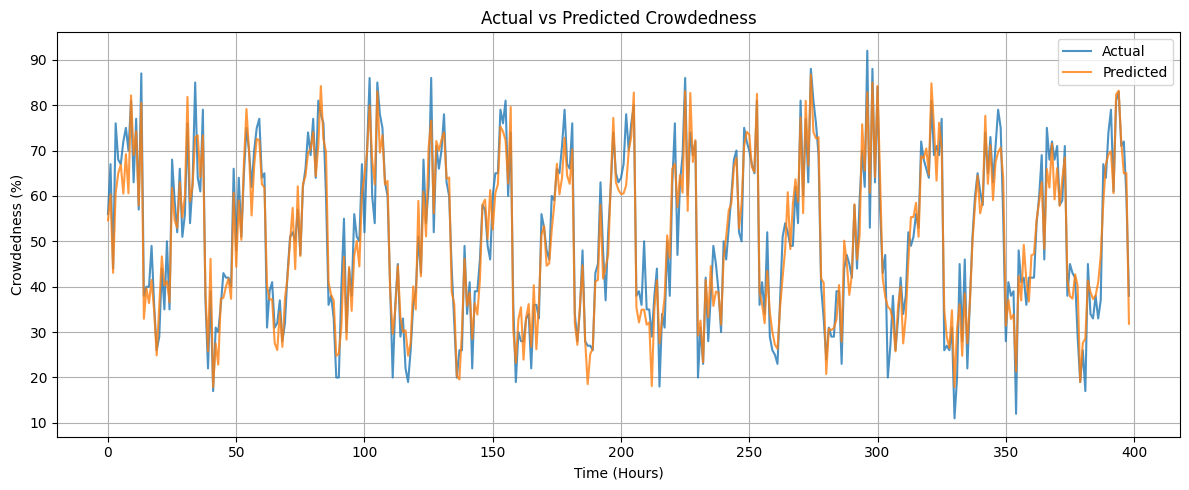

model training done
forecasting done
📈 Peak crowdedness: 82.79% at 08:00 PM
🟢 Least crowded: 43.40% at 04:00 AM
📊 Average crowdedness: 63.25%
forecast summary done


C:\Users\chris\AppData\Local\Temp\ipykernel_14760\2512430986.py:102: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_hours = pd.date_range(start=tomorrow.replace(hour=0), periods=24, freq='H')


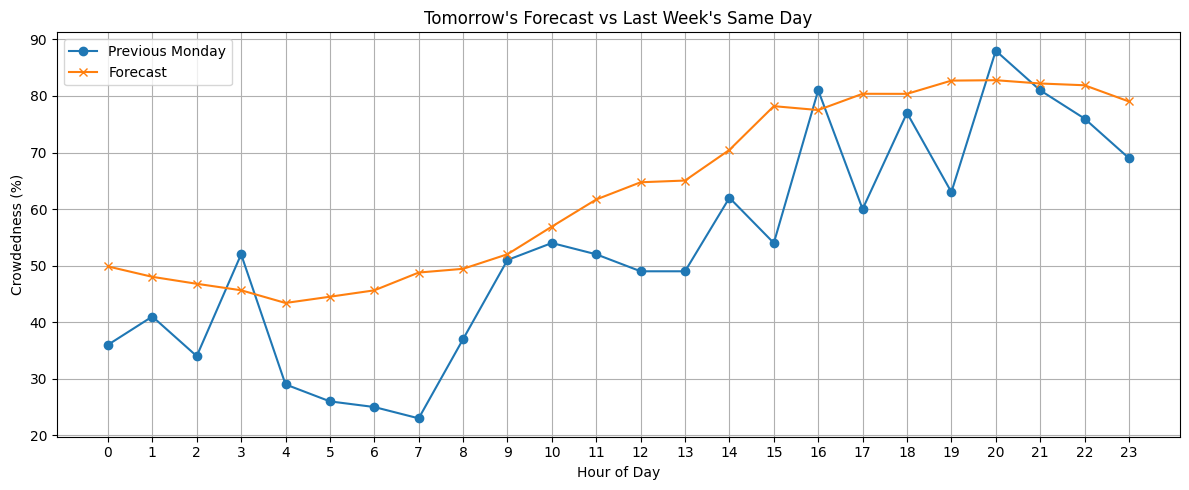

visualization done


In [ ]:
# ---- IMPORTS ----
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import pandas as pd


# ---- LOAD YOUR DATA ----
# Load the dataset
df = pd.read_csv("Data/dummy_data.csv", parse_dates=['timestamp'])
# Preview the first 5 rows
print(df.head())
# Ensure it's sorted by timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)
print('data done')

# ---------------------------------------------
# 1. TIME FEATURE ENGINEERING
# ---------------------------------------------
df['hour'] = df['timestamp'].dt.hour
df['day_of_week_num'] = df['timestamp'].dt.weekday

# Cyclical encoding
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week_num'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week_num'] / 7)
print('time feature engineering done')

# ---------------------------------------------
# 2. CATEGORICAL ENCODING
# ---------------------------------------------
df = pd.get_dummies(df, columns=['weather', 'wave_quality'], drop_first=True)
print('categorical encoding done')

# ---------------------------------------------
# 3. LAG & ROLLING FEATURES (PAST-ONLY)
# ---------------------------------------------
# Lag features: what was the crowdedness 1 day and 7 days ago
df['lag_1d'] = df['crowdedness'].shift(24)  # 24 hours ago
df['lag_7d'] = df['crowdedness'].shift(24 * 7)

# Rolling averages (excluding current hour to avoid leakage)
df['rolling_3d'] = df['crowdedness'].shift(1).rolling(window=24*3).mean()
df['rolling_7d'] = df['crowdedness'].shift(1).rolling(window=24*7).mean()
print('lag and rolling features done')

# Drop rows with NaNs caused by shifting/rolling
df = df.dropna().reset_index(drop=True)

# ---------------------------------------------
# 4. TRAIN-TEST SPLIT (TIME-AWARE)
# ---------------------------------------------
target = 'crowdedness'
features = df.columns.difference(['timestamp', 'crowdedness', 'day_of_week'])

X = df[features]
y = df[target]

split_index = int(len(df) * 0.8)
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]
print('train-test split done')

# ---------------------------------------------
# 5. MODEL TRAINING
# ---------------------------------------------
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label='Actual', alpha=0.8)
plt.plot(y_pred, label='Predicted', alpha=0.8)
plt.title('Actual vs Predicted Crowdedness')
plt.xlabel('Time (Hours)')
plt.ylabel('Crowdedness (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print('model training done')

# ---------------------------------------------
# 6. FORECASTING TOMORROW (WITH DYNAMIC FEATURES)
# ---------------------------------------------
tomorrow = df['timestamp'].max() + timedelta(days=1)
forecast_hours = pd.date_range(start=tomorrow.replace(hour=0), periods=24, freq='H')

# Simulated inputs
simulated_weather = 'Sunny'
simulated_wave_quality = 'Good'
simulated_temperature = 68

forecast_df = pd.DataFrame({
    'timestamp': forecast_hours,
    'hour': forecast_hours.hour,
    'temperature': simulated_temperature,
    'is_holiday': 0
})
forecast_df['day_of_week_num'] = forecast_df['timestamp'].dt.weekday

# Time encodings
forecast_df['hour_sin'] = np.sin(2 * np.pi * forecast_df['hour'] / 24)
forecast_df['hour_cos'] = np.cos(2 * np.pi * forecast_df['hour'] / 24)
forecast_df['dow_sin'] = np.sin(2 * np.pi * forecast_df['day_of_week_num'] / 7)
forecast_df['dow_cos'] = np.cos(2 * np.pi * forecast_df['day_of_week_num'] / 7)

# One-hot encodings (ensure same columns as training)
for col in ['weather_Cloudy', 'weather_Foggy', 'weather_Rainy', 'weather_Sunny']:
    forecast_df[col] = 1 if col == f'weather_{simulated_weather}' else 0
for col in ['wave_quality_Excellent', 'wave_quality_Fair', 'wave_quality_Good', 'wave_quality_Poor']:
    forecast_df[col] = 1 if col == f'wave_quality_{simulated_wave_quality}' else 0

# Generate lag/rolling per hour using recent history
last_24h = df.set_index('timestamp').loc[df['timestamp'].max() - pd.Timedelta(hours=23):, 'crowdedness'].values
forecast_df['lag_1d'] = last_24h  # size must be 24

last_7d = df.set_index('timestamp').loc[df['timestamp'].max() - pd.Timedelta(days=7) + pd.Timedelta(hours=1):, 'crowdedness']
forecast_df['lag_7d'] = np.tile(last_7d.mean(), 24)
forecast_df['rolling_3d'] = np.tile(df['crowdedness'].shift(1).rolling(window=24*3).mean().iloc[-1], 24)
forecast_df['rolling_7d'] = np.tile(df['crowdedness'].shift(1).rolling(window=24*7).mean().iloc[-1], 24)

# Predict forecast
forecast_X = forecast_df[X_train.columns]  # use same columns as model
forecast_df['predicted_crowdedness'] = model.predict(forecast_X)
print('forecasting done')

# ---------------------------------------------
# 7. FORECAST SUMMARY
# ---------------------------------------------
peak = forecast_df.loc[forecast_df['predicted_crowdedness'].idxmax()]
low = forecast_df.loc[forecast_df['predicted_crowdedness'].idxmin()]
avg = forecast_df['predicted_crowdedness'].mean()

print(f"📈 Peak crowdedness: {peak['predicted_crowdedness']:.2f}% at {peak['timestamp'].strftime('%I:%M %p')}")
print(f"🟢 Least crowded: {low['predicted_crowdedness']:.2f}% at {low['timestamp'].strftime('%I:%M %p')}")
print(f"📊 Average crowdedness: {avg:.2f}%")
print('forecast summary done')

# ---------------------------------------------
# 8. VISUALIZATION (FORECAST vs PREVIOUS SAME DAY)
# ---------------------------------------------
# Get previous same weekday
target_weekday = forecast_df['timestamp'].dt.weekday[0]
past_same_day = df[df['day_of_week_num'] == target_weekday]
previous_date = past_same_day[past_same_day['timestamp'] < forecast_df['timestamp'][0]].timestamp.max().date()
previous_df = df[df['timestamp'].dt.date == previous_date]

plt.figure(figsize=(12, 5))
plt.plot(previous_df['timestamp'].dt.hour, previous_df['crowdedness'], label=f'Previous {previous_df["timestamp"].dt.day_name().iloc[0]}', marker='o')
plt.plot(forecast_df['timestamp'].dt.hour, forecast_df['predicted_crowdedness'], label='Forecast', marker='x')
plt.title("Tomorrow's Forecast vs Last Week's Same Day")
plt.xlabel("Hour of Day")
plt.ylabel("Crowdedness (%)")
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()
print('visualization done')